In [33]:
import src
from src.utils import create_gif, load_model
from torchvision.transforms import Compose, Lambda, ToPILImage
import numpy as np
import torch
%matplotlib inline

In [35]:
beta_start = 0.0001
beta_end = 0.02
timesteps = 300
image_size = 32
num_channels = 3
n_images = 4
batch_size = n_images**2
device = "cpu"
epoch = 50

In [36]:
scheduler = src.CosineScheduler(beta_start=beta_start, beta_end=beta_end, timesteps=timesteps)

In [37]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

forward_diffusion = src.ForwardDiffusion(sqrt_alphas_cumprod=scheduler.sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod=scheduler.sqrt_one_minus_alphas_cumprod, reverse_transform=reverse_transform)


In [38]:
device = torch.device(device)

In [39]:
model = src.DDPM(n_features=image_size, in_channels=num_channels, channel_scale_factors=(1, 2, 4,))
load_model(epoch=epoch, model=model, device=device)

sampler = src.Sampler(betas=scheduler.betas, sqrt_one_minus_alphas_cumprod=scheduler.sqrt_one_minus_alphas_cumprod, sqrt_one_by_alphas=scheduler.sqrt_one_by_alphas, posterior_variance=scheduler.posterior_variance, timesteps=timesteps)


In [40]:
# Get samples
samples = sampler.sample(model=model, image_size=image_size, batch_size=batch_size, channels=num_channels)


MovieWriter ffmpeg unavailable; using Pillow instead.


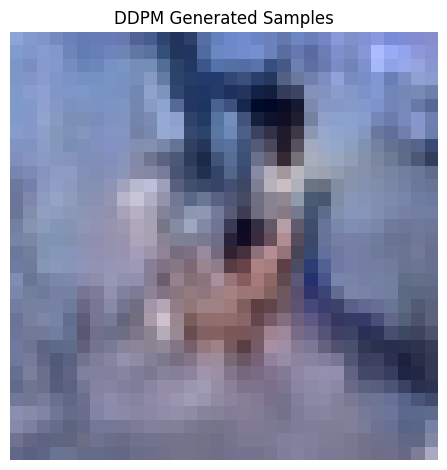

In [ ]:
create_gif(samples=samples, image_size=image_size, num_channels=num_channels, timesteps=timesteps, n_images=n_images // 4)

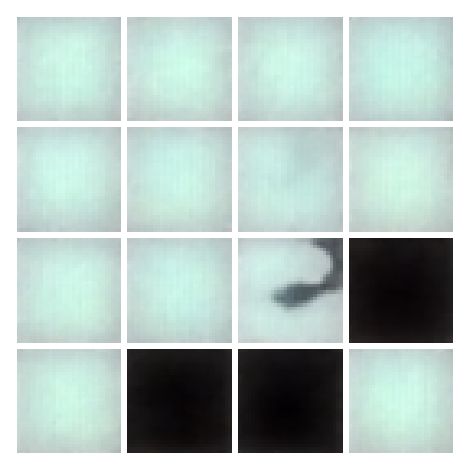

In [41]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
fig = plt.figure()
n_square_images = torch.tensor(samples[-1][:batch_size].reshape(batch_size, num_channels, image_size, image_size))
image_grid = make_grid(n_square_images, nrow=n_images, padding=2, pad_value=1, normalize=True)
img_grid = plt.imshow(image_grid.permute(1, 2, 0), animated=True)
plt.axis("off")
plt.tight_layout()
fig.savefig("ddpm_generated_samples_cosine.png")